In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
import functions as fc
import os
from Metropolis import Metropolis  #  On importe la classe.
from tqdm import tqdm # Pour afficher où on est rendu dans la série de simulations.
from scipy.integrate import simps
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.optimize import minimize


data_folder = "Data/" # Ne pas oublier le "/" après. Si en windows, c'est "\"
top_dir = os.getcwd()
plt.rcParams['font.size'] = 16

## 1 - Simulation exploratoire

In [165]:
start_time = time.time()

#metro = Metropolis(lattice_size=64, betaJ=0.7, magnetic_field=0.0, pourcentage_up=0)

#metro.plot_hysteresis(h_low=-2, h_high=2, resolution=0.1, fast=True)

# Créer une instance de la classe Metropolis avec les paramètres souhaités
# def __init__(self, lattice_size, betaJ, magnetic_field, energy=None, previous_lattice=None, pourcentage_up=0.60, seed=None):

metro = Metropolis(lattice_size=64, 
                    magnetic_field=0.1, 
                    betaJ=1, 
                    pourcentage_up=0.6, 
                    seed=42,
                    )

#def find_equilibrium(self, n_iter=30000, buffer = 5000, run_max=True, fluct_eq=0.002, fast=True, save_all=False):
#list_lattices, energy, spin_mean_list, energy_list

# Trouver l'état d'équilibre en utilisant la méthode "find_equilibrium"
lattices, energy, spin_means, energy_list = metro.find_equilibrium()
step_algo = np.arange(0, len(spin_means), 1) # Itérations de la "descente" Metropolis

print("Temps d'exécution : ", time.time() - start_time)


Temps d'exécution :  0.13394403457641602


/tmp/ipykernel_46324/1230408802.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/tmp/ipykernel_46324/1230408802.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


Paramètres ajustés : a = 6834.6918972291705, b = 0.00010886412121709965, c = -7938.292105234541
Constante de temps (tau) : 9185.762846565161


<Figure size 1000x600 with 0 Axes>

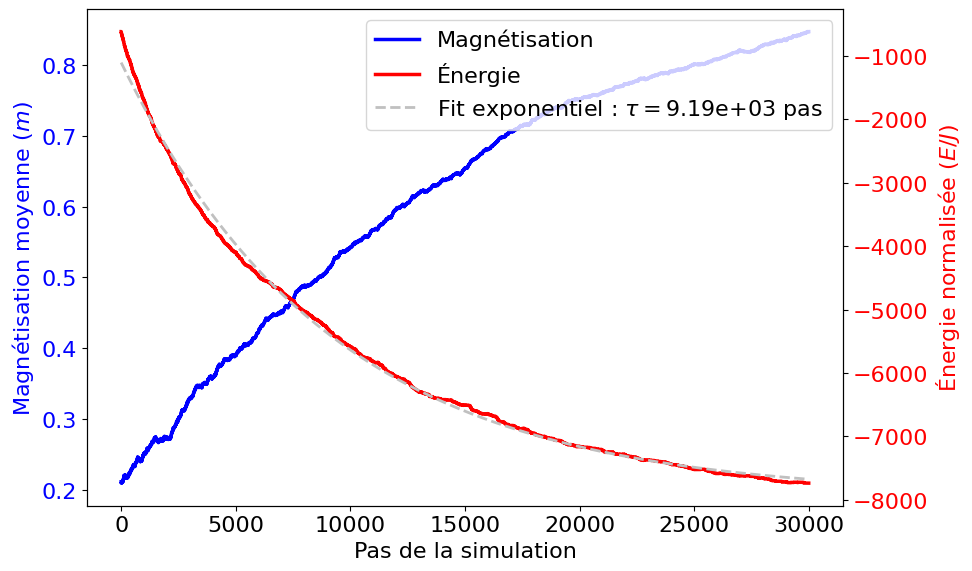

In [163]:

# xponentielle décroissante avec constante
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(exp_decay, step_algo, energy_list, p0=(1, 0.001, energy_list[-1]))

a_fit, b_fit, c_fit = popt
print(f"Paramètres ajustés : a = {a_fit}, b = {b_fit}, c = {c_fit}")
tau_fit = b_fit**(-1)
print(f"Constante de temps (tau) : {tau_fit}")

# Tracer la figure avec l'ajustement
plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(step_algo, spin_means, 'b-', linewidth=2.5, label='Magnétisation')
ax1.set_xlabel("Pas de la simulation")
ax1.set_ylabel(r"Magnétisation moyenne ($m$)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(step_algo, energy_list, 'r-', linewidth=2.5, label='Énergie')
ax2.plot(step_algo, exp_decay(step_algo, *popt), color="silver", linestyle="--", linewidth=2, label=r"Fit exponentiel : $\tau = $" + f"{tau_fit:.3} pas")
ax2.set_ylabel(r"Énergie normalisée ($E/J$)", color='r')
ax2.tick_params(axis='y', labelcolor='r')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.tight_layout()
plt.savefig("figures/fit_energie.pdf")
plt.show()

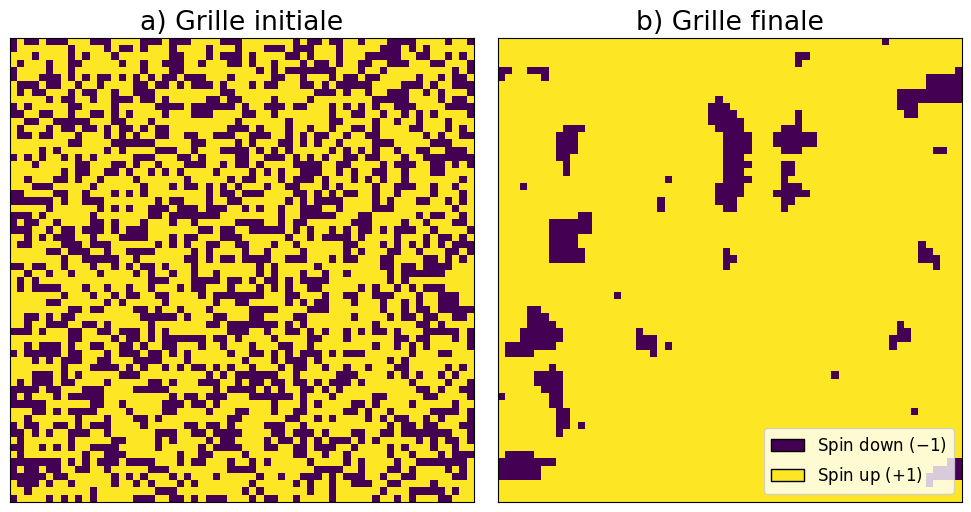

In [416]:
from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Normalisation pour la palette viridis
norm = Normalize(vmin=-1, vmax=1)
cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(lattices[0], vmin=-1, vmax=1, cmap=cmap)
plt.title("a) Grille initiale")
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(lattices[-1], vmin=-1, vmax=1, cmap=cmap)
plt.title("b) Grille finale")
plt.xticks([])
plt.yticks([])
# Ajouter une légende avec la palette viridis en bas à droite de la sous-figure de droite
legend_elements = [
    Patch(facecolor=cmap(norm(-1)), edgecolor='black', label=r'Spin down ($-1$)'),
    Patch(facecolor=cmap(norm(1)), edgecolor='black', label=r'Spin up ($+1$)')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

plt.tight_layout()
plt.savefig("figures/exemple_grille_avant_apres.pdf")
plt.show()


## 2 - Simulation d'une série à betaJ fixé

In [5]:
def run_batch_simulations(h_vec, n_seeds, base_path, betaJ=0.5, size=64, enreg=True):

    file_suffix=".h5"

    seed_stack = []
    mag_f_vec_stack = []
    E_f_vec_stack = []
    grille_f_vec_stack = []

    for i in range(n_seeds):
        seed = int(i+1) # Arbitrairement, on injecte i comme seed!
        seed_stack.append(i)
        derniere_grille = None # On réinitialise la grille à chaque seed, pour une nouvelle boucle d'hystérésis

        mag_f_vec = [] # Vecteur de <M>_f selon vecteur de h (pour seed donnée)
        E_f_vec = [] # Vecteur de E_f selon vecteur de h (pour seed donnée)
        grille_f_vec = [] # Liste contenant les grilles finales, pour chaque h balayé

        metro = Metropolis(lattice_size=size,
            magnetic_field = 0,
            betaJ = betaJ, 
            pourcentage_up = 0.5, 
            seed=seed,
            )

        for h in tqdm(h_vec, desc="Variation du champ magnétique"):

            metro.h = h # Mise à jour du champ magnétique
            metro.previous_lattice = derniere_grille
            lattices_timeseries, _, mag_timeseries, energy_timeseries = metro.find_equilibrium()

            mag_f_vec.append(mag_timeseries[-1])
            E_f_vec.append(energy_timeseries[-1])
            derniere_grille = lattices_timeseries[-1] # Enregistrement de la dernière grille, pour repartir d'elle comme condition initiale
            grille_f_vec.append(derniere_grille)

        mag_f_vec_stack.append(mag_f_vec)
        E_f_vec_stack.append(E_f_vec)
        grille_f_vec_stack.append(grille_f_vec)

    if enreg:
        # Fichier propre à chaque seed
        filename = f"{base_path}{file_suffix}"
        print("Enregistrement de " + filename)

        data_dict = {
            # Éléments dynamiques, propres à aux simulations individuelles
            "grille_f": np.array(grille_f_vec_stack),
            "E_f": np.array(E_f_vec_stack),
            "M_f": np.array(mag_f_vec_stack),
            "betaJ": np.array([metro.betaJ]),
            "h": np.array(h_vec),

            # Éléments statiques, propres à la batch de simuls
            "seed" : seed_stack,
            "pourcentage_up": metro.up_perc
        }

        fc.save_hdf5(filename, data_dict)

    return np.array(mag_f_vec_stack), np.array(E_f_vec_stack), np.array(grille_f_vec_stack)


In [5]:
enreg=False
simulation_type = "hysteresis" # hysteresis, ou quelque chose d'autre (à suivre)
branche_n_points = 5
h_low = -1
h_high = 1
close_loop = True

h_vec = np.concatenate([np.linspace(0, h_high, branche_n_points), np.linspace(h_high, h_low, branche_n_points*2 + 1), np.linspace(h_low, h_high, 2*branche_n_points+1)])
betaJ = 0.05

print("betaJ : ", betaJ)
print("Simulation : ", simulation_type)
print("Valeurs de h balayées :", h_vec)

betaJ :  0.05
Simulation :  hysteresis
Valeurs de h balayées : [ 0.    0.25  0.5   0.75  1.    1.    0.8   0.6   0.4   0.2   0.   -0.2
 -0.4  -0.6  -0.8  -1.   -1.   -0.8  -0.6  -0.4  -0.2   0.    0.2   0.4
  0.6   0.8   1.  ]


In [6]:
sim_id = len(fc.identify_files(top_dir+"/Data", keywords=[simulation_type]))
sim_folder = top_dir + "/Data/" + simulation_type + f"_betaJ={betaJ}".format(sim_id)

if enreg:
    fc.create_folder(sim_folder)

filename = sim_folder + "/" + "simul_" + simulation_type # Juste le noyau du nom de fichier
mag_data, Ef_data, grille_data = run_batch_simulations(h_vec, n_seeds=3, betaJ=betaJ, base_path=filename, enreg=enreg)

Variation du champ magnétique: 100%|██████████| 27/27 [00:03<00:00,  7.59it/s]


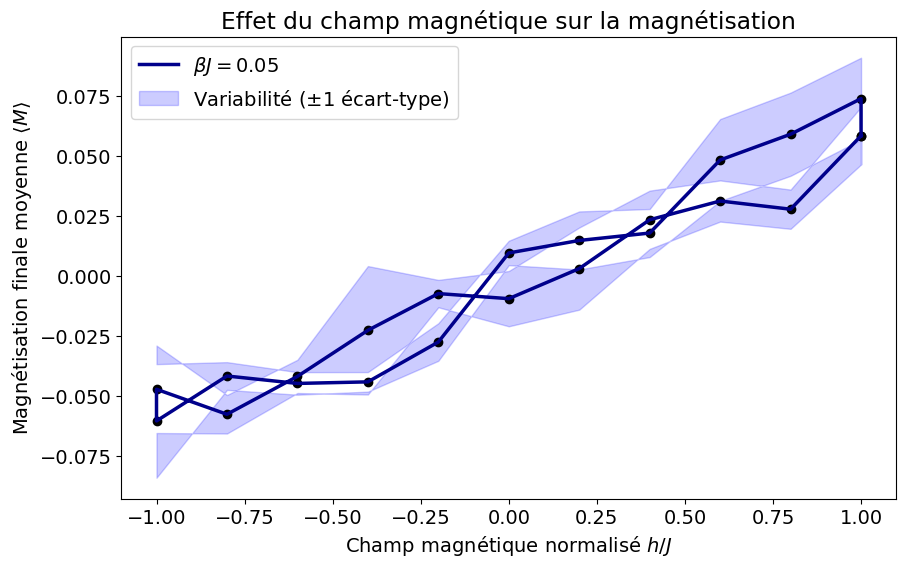

In [ ]:
# Retirer les 4 premiers points pour éviter de voir la branche initiale de magnétisation
h_vec_filtered = h_vec[branche_n_points:]
mean_mag = np.mean(mag_data, axis=0)
std_mag = np.std(mag_data, axis=0)
mean_mag_filtered = mean_mag[branche_n_points:]
std_mag_filtered = std_mag[branche_n_points:]

if close_loop: 
    h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
    mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
    std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])

plt.figure(figsize=(10,6))
plt.plot(h_vec_filtered, mean_mag_filtered, color="darkBlue", linewidth=2.5, label=r"$\beta J = $" + f"{betaJ:.2f}")
plt.fill_between(h_vec_filtered, 
                 mean_mag_filtered - std_mag_filtered, 
                 mean_mag_filtered + std_mag_filtered, 
                 color="blue", alpha=0.2, label=r"Variabilité ($\pm 1$ écart-type)")
plt.scatter(h_vec_filtered, mean_mag_filtered, color="black")
plt.xlabel(r"Champ magnétique normalisé $H/J$")
plt.ylabel(r"Magnétisation finale moyenne $m$")
plt.title("Effet du champ magnétique sur la magnétisation")
plt.xlim(1.1*h_low, 1.1*h_high)
plt.legend()
plt.show()

# 3.1 - Simulations en séries pour plusieurs boucles d'hystérèse

In [11]:
enreg=True
n_seeds = 5
simulation_type = "hysteresis" # hysteresis, ou quelque chose d'autre (à suivre)
branche_n_points = 15
h_low = -1.55
h_high = 1.55
close_loop = True

# On balaye aussi les betaJ pour la figure avec plusieurs boucles d'hystérèse
betaJ_vec = np.array([0.2, 0.40, 0.60])  #np.linspace(0.25, 0.75, 3)


h_vec = np.concatenate([np.linspace(0, h_high, branche_n_points), np.linspace(h_high, h_low, branche_n_points*2 + 1), np.linspace(h_low, h_high, 2*branche_n_points+1)])
print("Simulation : ", simulation_type)
print("Valeurs de h balayées :", h_vec)

print("betaJ : ", betaJ_vec)

Simulation :  hysteresis
Valeurs de h balayées : [ 0.          0.11071429  0.22142857  0.33214286  0.44285714  0.55357143
  0.66428571  0.775       0.88571429  0.99642857  1.10714286  1.21785714
  1.32857143  1.43928571  1.55        1.55        1.44666667  1.34333333
  1.24        1.13666667  1.03333333  0.93        0.82666667  0.72333333
  0.62        0.51666667  0.41333333  0.31        0.20666667  0.10333333
  0.         -0.10333333 -0.20666667 -0.31       -0.41333333 -0.51666667
 -0.62       -0.72333333 -0.82666667 -0.93       -1.03333333 -1.13666667
 -1.24       -1.34333333 -1.44666667 -1.55       -1.55       -1.44666667
 -1.34333333 -1.24       -1.13666667 -1.03333333 -0.93       -0.82666667
 -0.72333333 -0.62       -0.51666667 -0.41333333 -0.31       -0.20666667
 -0.10333333  0.          0.10333333  0.20666667  0.31        0.41333333
  0.51666667  0.62        0.72333333  0.82666667  0.93        1.03333333
  1.13666667  1.24        1.34333333  1.44666667  1.55      ]
betaJ :  [0.2

/home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_06
betaJ :  0.2


Variation du champ magnétique: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_06/simul_betaJ=0.20.h5


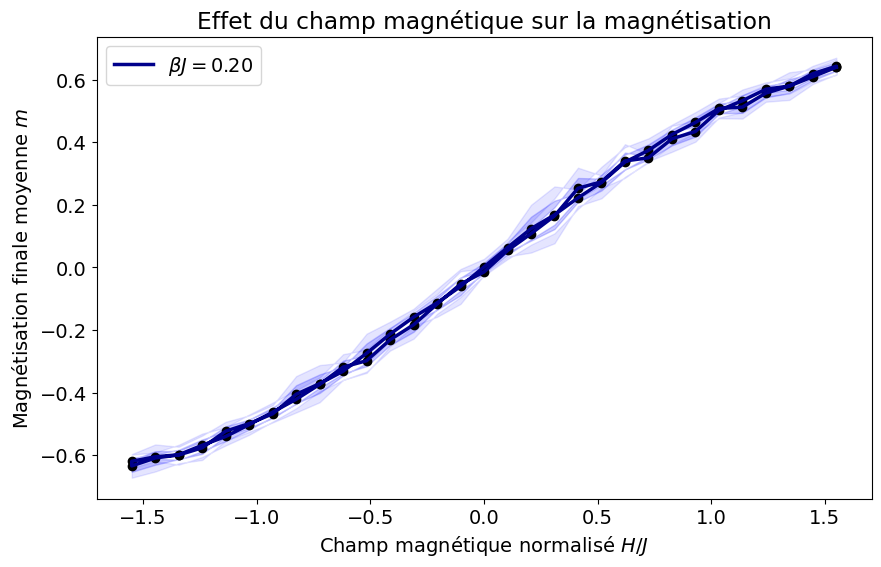

betaJ :  0.4


Variation du champ magnétique: 100%|██████████| 77/77 [00:10<00:00,  7.22it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_06/simul_betaJ=0.40.h5


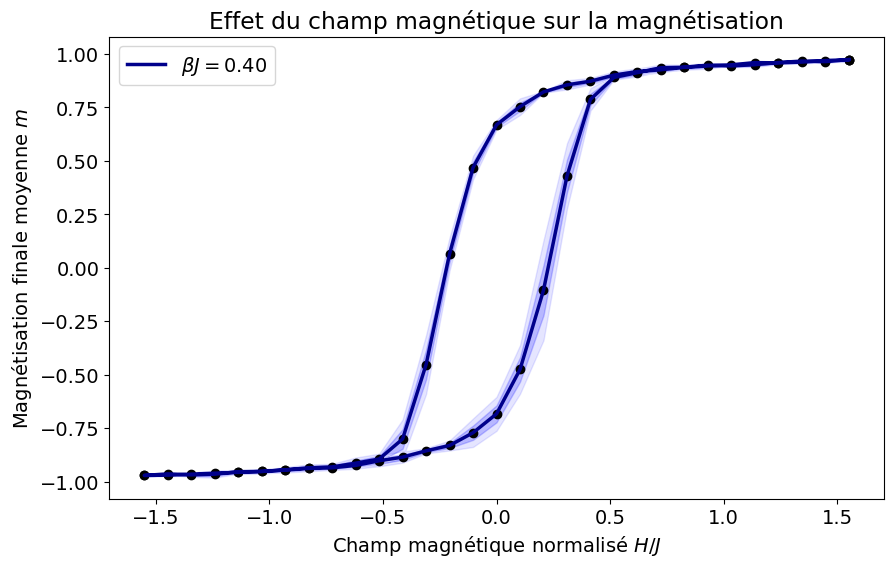

betaJ :  0.6


Variation du champ magnétique: 100%|██████████| 77/77 [00:10<00:00,  7.13it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_06/simul_betaJ=0.60.h5


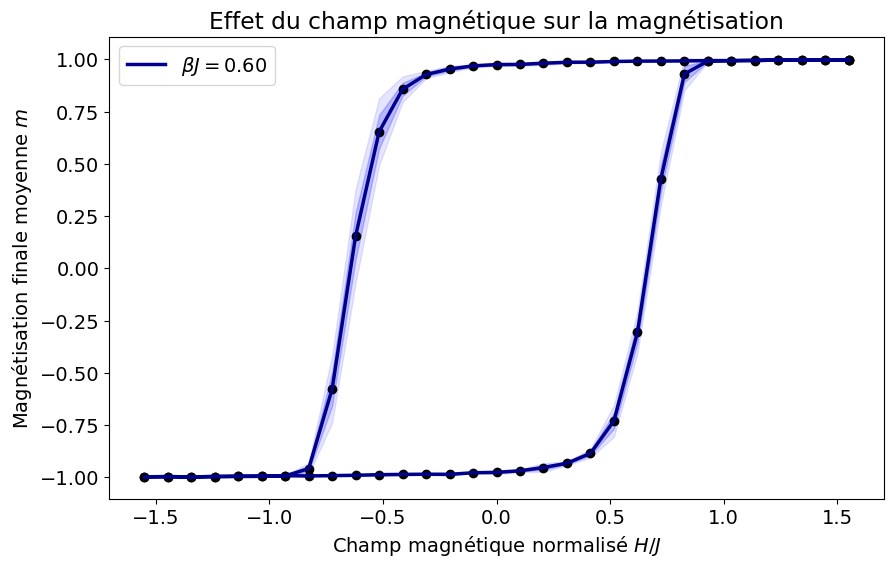

In [12]:
sim_id = len(fc.identify_files(top_dir+"/Data", keywords=[simulation_type]))
sim_folder = top_dir + "/Data/" + simulation_type + f"_{fc.fill_index(sim_id)}"
print(sim_folder)
if enreg:
    fc.create_folder(sim_folder)

for betaJ in betaJ_vec:

    print("betaJ : ", betaJ)

    filename = sim_folder + "/" + f"simul_betaJ={betaJ:.2f}"  # Juste le noyau du nom de fichier
    mag_data, Ef_data, grille_data = run_batch_simulations(h_vec, n_seeds=n_seeds, betaJ=betaJ, base_path=filename, enreg=enreg)

    h_vec_filtered = h_vec[branche_n_points:]
    mean_mag = np.mean(mag_data, axis=0)
    std_mag = np.std(mag_data, axis=0)
    mean_mag_filtered = mean_mag[branche_n_points:]
    std_mag_filtered = std_mag[branche_n_points:]


    if close_loop: 
        h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
        mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
        std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])

    plt.figure(figsize=(10,6))
    plt.plot(h_vec_filtered, mean_mag_filtered, color="darkBlue", linewidth=2.5, label=r"$\beta J = $" + f"{betaJ:.2f}")
    plt.fill_between(h_vec_filtered, 
                    mean_mag_filtered - std_mag_filtered, 
                    mean_mag_filtered + std_mag_filtered, 
                    color="blue", alpha=0.2)#, label=r"Variabilité ($\pm 1$ écart-type)")
    plt.fill_between(h_vec_filtered, 
                    mean_mag_filtered - std_mag_filtered*2, 
                    mean_mag_filtered + std_mag_filtered*2, 
                    color="blue", alpha=0.1)#, label=r"Variabilité ($\pm 1$ écart-type)")
    plt.scatter(h_vec_filtered, mean_mag_filtered, color="black")
    plt.xlabel(r"Champ magnétique normalisé $H/J$")
    plt.ylabel(r"Magnétisation finale moyenne $ m $")
    plt.title("Effet du champ magnétique sur la magnétisation")
    plt.xlim(1.1*h_low, 1.1*h_high)
    plt.legend()
    plt.show()

# 3.2 - Chargement des données de simulation


In [175]:
sim_id = 4
sim_folder = top_dir + "/Data/" + simulation_type + f"_{fc.fill_index(sim_id)}"
print(sim_folder)

files = fc.identify_files(sim_folder)
betaJ_vec = []

for i,file in enumerate(files):
    # Charger betaJ_vec à la main
    data = fc.load_hdf5(sim_folder + "/" + file)
    if i == 0:
        print(data.keys())
    betaJ_vec.append(float(data["betaJ"]))

betaJ_vec = np.asarray(betaJ_vec)
print(betaJ_vec)

/home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_04
dict_keys(['E_f', 'M_f', 'betaJ', 'grille_f', 'h', 'pourcentage_up', 'seed'])
[0.1  0.26 0.42 0.58 0.74 0.9  1.06 1.22 1.38 1.54 1.7  1.86 2.02 2.18
 2.34 2.5 ]


/tmp/ipykernel_46324/3068427477.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')  # Utiliser 'magma_r' pour inverser les couleurs


Chargement des données pour betaJ = 0.10
Chargement des données pour betaJ = 0.26
Chargement des données pour betaJ = 0.42
Chargement des données pour betaJ = 0.58
Chargement des données pour betaJ = 0.74
Chargement des données pour betaJ = 0.90
Chargement des données pour betaJ = 1.06
Chargement des données pour betaJ = 1.22
Chargement des données pour betaJ = 1.38
Chargement des données pour betaJ = 1.54
Chargement des données pour betaJ = 1.70
Chargement des données pour betaJ = 1.86
Chargement des données pour betaJ = 2.02
Chargement des données pour betaJ = 2.18
Chargement des données pour betaJ = 2.34
Chargement des données pour betaJ = 2.50


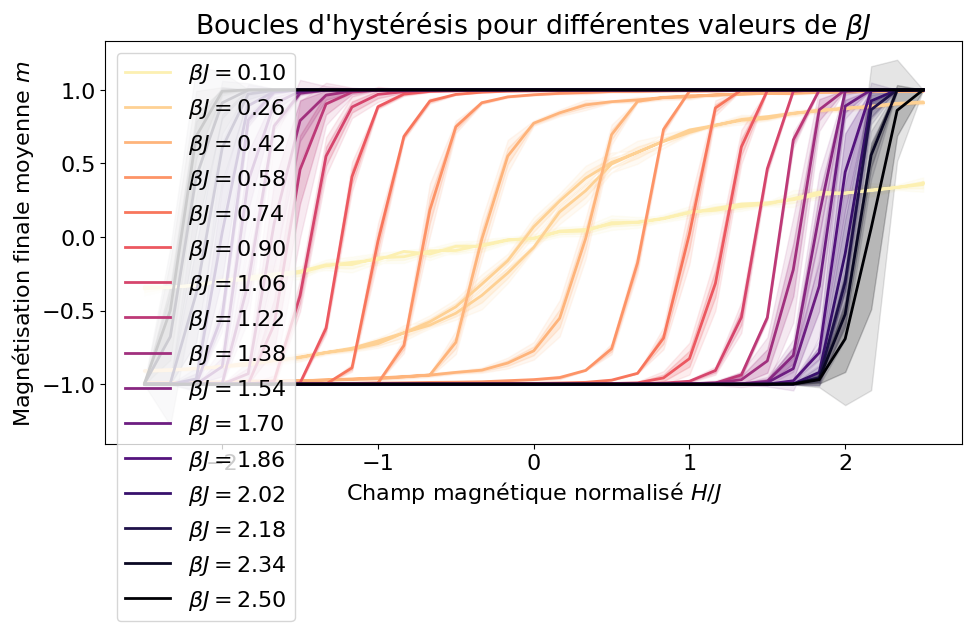

In [177]:
cmap = plt.cm.get_cmap('magma_r')  # Utiliser 'magma_r' pour inverser les couleurs
norm = plt.Normalize(vmin=min(betaJ_vec)*0.25, vmax=max(betaJ_vec))

plt.figure(figsize=(10, 6))

# Parcourir les différentes valeurs de betaJ
for betaJ in betaJ_vec:
    color = cmap(norm(betaJ))

    print(f"Chargement des données pour betaJ = {betaJ:.2f}")

    # Chemin vers le fichier HDF5 correspondant à cette valeur de betaJ
    filename = os.path.join(sim_folder, f"simul_betaJ={betaJ:.2f}.h5")

    if not os.path.exists(filename):
        print(f"Fichier non trouvé : {filename}")
        continue

    # Charger les données depuis le fichier HDF5
    with h5py.File(filename, "r") as f:
        mag_data = f["M_f"][:]  # Magnétisation finale
        h_vec_loaded = f["h"][:]  # Champ magnétique utilisé


    # Calculer la moyenne et l'écart-type de la magnétisation
    mean_mag = np.mean(mag_data, axis=0)
    std_mag = np.std(mag_data, axis=0)

    # Filtrer les données pour retirer les premiers points
    h_vec_filtered = h_vec_loaded[branche_n_points:]
    mean_mag_filtered = mean_mag[branche_n_points:]
    std_mag_filtered = std_mag[branche_n_points:]

    if close_loop:
        h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
        mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
        std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])

    # Tracer la courbe pour cette valeur de betaJ
    plt.plot(h_vec_filtered, mean_mag_filtered, color=color, linewidth=2, label=rf"$\beta J = {betaJ:.2f}$")
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - std_mag_filtered,
        mean_mag_filtered + std_mag_filtered,
        alpha=0.2, color=color
    )
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - 2*std_mag_filtered,
        mean_mag_filtered + 2*std_mag_filtered,
        alpha=0.1, color=color
    )

plt.xlabel(r"Champ magnétique normalisé $H/J$")
plt.ylabel(r"Magnétisation finale moyenne $ m $")
plt.title("Boucles d'hystérésis pour différentes valeurs de $\\beta J$")
plt.legend()
plt.tight_layout()
#plt.savefig("figures/boucles_hystersis.pdf")
plt.show()

# 4 - Analyse

## 4.1 - Calcul de l'aire des boucles d'hystérésis

/tmp/ipykernel_46324/1098992906.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')  # Utiliser 'magma_r' pour inverser les couleurs


Chargement des données pour betaJ = 0.10
Chargement des données pour betaJ = 0.26
Chargement des données pour betaJ = 0.42
Chargement des données pour betaJ = 0.58
Chargement des données pour betaJ = 0.74
Chargement des données pour betaJ = 0.90
Chargement des données pour betaJ = 1.06
Chargement des données pour betaJ = 1.22
Chargement des données pour betaJ = 1.38
Chargement des données pour betaJ = 1.54
Chargement des données pour betaJ = 1.70
Chargement des données pour betaJ = 1.86
Chargement des données pour betaJ = 2.02
Chargement des données pour betaJ = 2.18
Chargement des données pour betaJ = 2.34
Chargement des données pour betaJ = 2.50


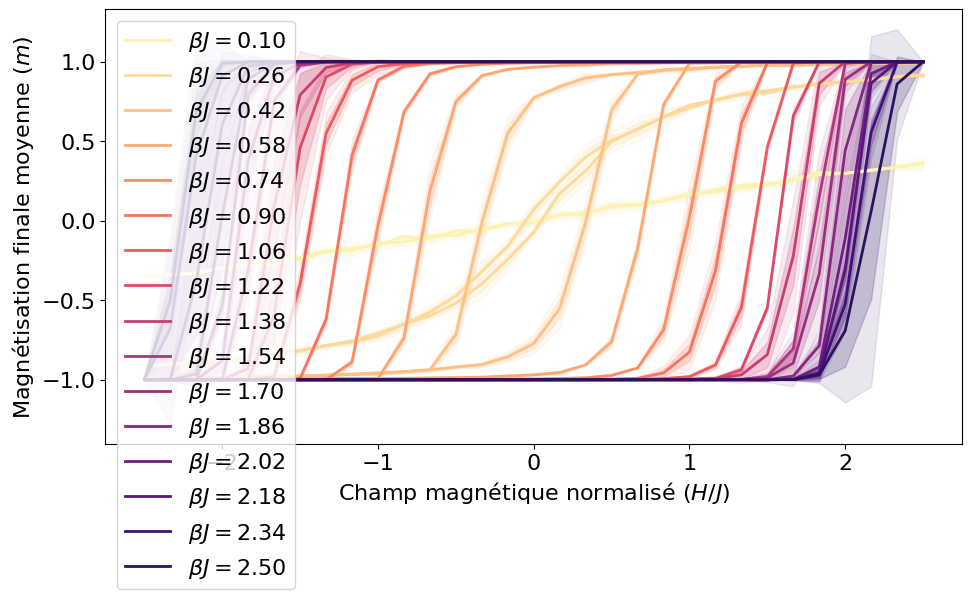

In [178]:
betaJ_list = []
area_means = []
area_stds = []

plt.figure(figsize=(10, 6))

cmap = plt.cm.get_cmap('magma_r')  # Utiliser 'magma_r' pour inverser les couleurs
norm = plt.Normalize(vmin=min(betaJ_vec)*0.3, vmax=max(betaJ_vec)*1.2)

for betaJ in betaJ_vec:
    color = cmap(norm(betaJ))

    print(f"Chargement des données pour betaJ = {betaJ:.2f}")

    # Chemin vers le fichier hdf5 correspondant
    filename = os.path.join(sim_folder, f"simul_betaJ={betaJ:.2f}.h5")

    if not os.path.exists(filename):
        print(f"Fichier non trouvé : {filename}")
        continue

    with h5py.File(filename, "r") as f:
        mag_data = f["M_f"][:]  # Magnétisation finale
        h_vec_loaded = f["h"][:]  # Champ magnétique utilisé

    # Calculer la moyenne et l'écart-type de la magnétisation
    mean_mag = np.mean(mag_data, axis=0)
    std_mag = np.std(mag_data, axis=0)

    # Filtrer les données
    h_vec_filtered = h_vec_loaded[branche_n_points:]
    mean_mag_filtered = mean_mag[branche_n_points:]
    std_mag_filtered = std_mag[branche_n_points:]

    mag_data_filtered = mag_data[:, branche_n_points:]  # Filtrer aussi chaque seed

    if close_loop:
        h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
        mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
        std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])
        mag_data_filtered = np.concatenate([mag_data_filtered, mag_data_filtered[:, [0]]], axis=1)

    # Calcul des aires individuelles
    areas = np.array([
        np.abs(np.trapz(mag_data_filtered[i], h_vec_filtered))
        for i in range(mag_data_filtered.shape[0])
    ])

    # Moyenne et écart-type des aires
    area_mean = np.mean(areas)
    area_std = np.std(areas)

    betaJ_list.append(betaJ)
    area_means.append(area_mean)
    area_stds.append(area_std)

    # Tracer la courbe pour cette valeur de betaJ
    plt.plot(h_vec_filtered, mean_mag_filtered, color=color, linewidth=2, label=rf"$\beta J = {betaJ:.2f}$")
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - std_mag_filtered,
        mean_mag_filtered + std_mag_filtered,
        alpha=0.2, color=color
    )
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - 2*std_mag_filtered,
        mean_mag_filtered + 2*std_mag_filtered,
        alpha=0.1, color=color
    )

plt.xlabel(r"Champ magnétique normalisé ($H/J$)")
plt.ylabel(r"Magnétisation finale moyenne ($ m $)")
#plt.title("Boucles d'hystérésis pour différentes valeurs de $\\beta J$")
plt.legend()
plt.tight_layout()
#plt.savefig("figures/boucles_hystersis.pdf")
plt.show()


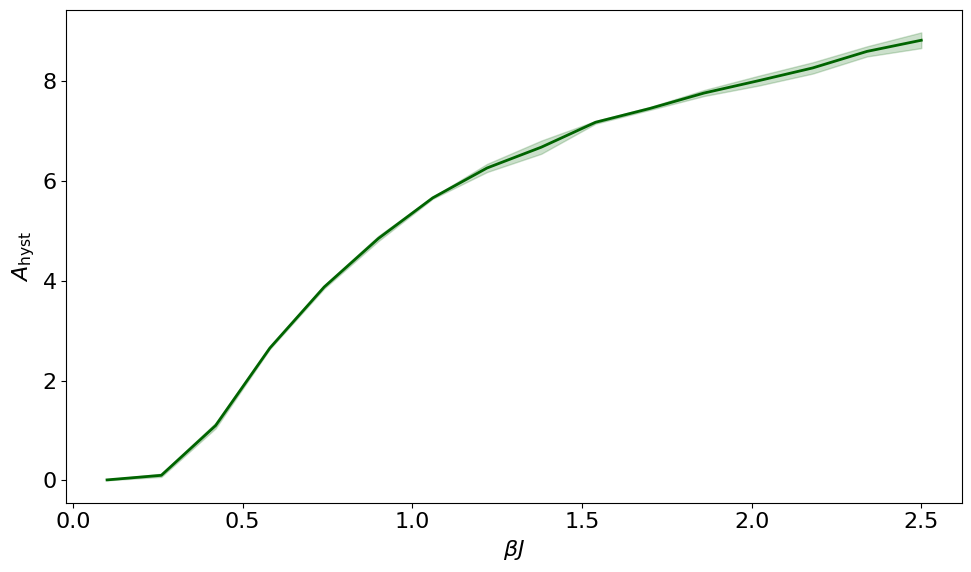

In [179]:
plt.figure(figsize=(10,6))
plt.plot(betaJ_list, area_means, color="darkGreen", linewidth=2, alpha=1)
plt.fill_between(betaJ_list, 
                 np.array(area_means) - np.array(area_stds), 
                 np.array(area_means) + np.array(area_stds), 
                 color="darkGreen", alpha=0.2, label=r"Variabilité ($\pm 1$ écart-type)")
plt.xlabel(r"$\beta J$")
plt.ylabel(r"$A_{\mathrm{hyst}}$")
#plt.title(r"Évolution de l'aire d'hystérésis avec $\beta J$")
plt.tight_layout()
#plt.savefig("figures/Aires_selon_betaJ.pdf")
plt.show()

## 4.2 Validation avec modèle de Landau

#### 4.2.1 - Diagramme de bifurcation

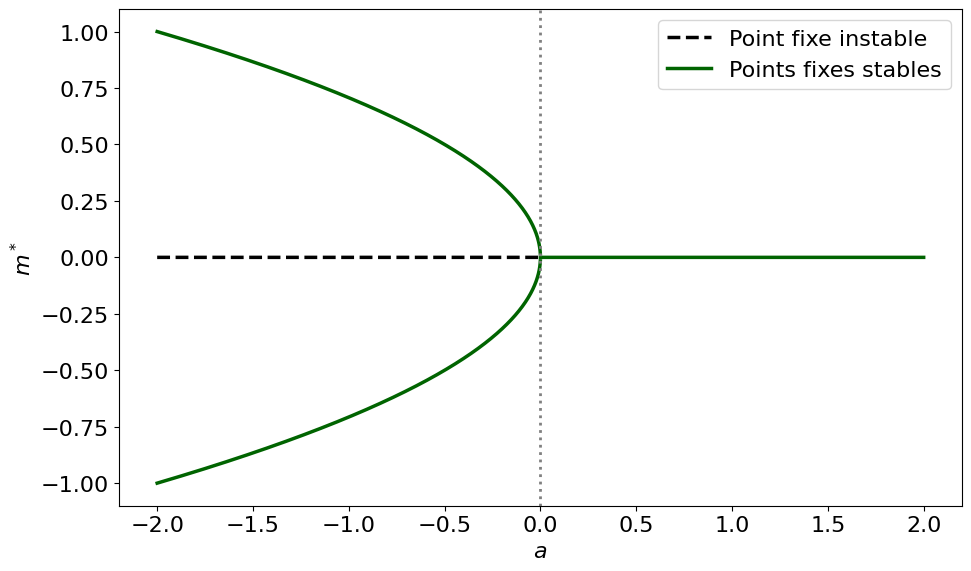

In [444]:

# Paramètres de Landau
b = 2  # fixé pour normaliser
# balayage du paramètre a
a_vals = np.linspace(-2, 2, 4000)
a_vals_pos = np.linspace(0,2,2000)
a_vals_neg = np.linspace(-2,0,2000)

# Solutions m
def m_stable(a, b):
    """Branches stables."""
    return np.sqrt(-a/(b))

# Création des branches
m0 = np.zeros_like(a_vals_neg)  # m = 0 existe toujours
m0_pos = np.zeros_like(a_vals_pos)
m_pos = np.zeros_like(a_vals)
m_neg = np.zeros_like(a_vals)

# Remplir uniquement où a < 0
mask = a_vals < 0
m_pos[mask] = m_stable(a_vals[mask], b)
m_neg[mask] = -m_stable(a_vals[mask], b)

# Tracé
plt.figure(figsize=(10,6))
plt.plot(a_vals_neg, m0, 'k--', linewidth=2.5, label=r"Point fixe instable")
plt.plot(a_vals_pos, m0_pos, color="darkGreen", linewidth=2.5 )
plt.plot(a_vals[mask], np.clip(m_pos[mask], -1,1), 'darkgreen', linewidth=2.5, label=r"Points fixes stables")
plt.plot(a_vals[mask], np.clip(m_neg[mask], -1,1), 'darkgreen', linewidth=2.5)
plt.xlabel(r"$a$")
plt.ylabel(r"$m^*$")
#plt.title(r"Diagramme de bifurcation du modèle de Landau ($h=0$, $b=1$)")
plt.axvline(0, color='grey', linestyle=':', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig("figures/diag_bifurc_Landau_h=0.pdf")
plt.show()


### 4.2.2 - Visualisation de toutes les solutions pour h balayé

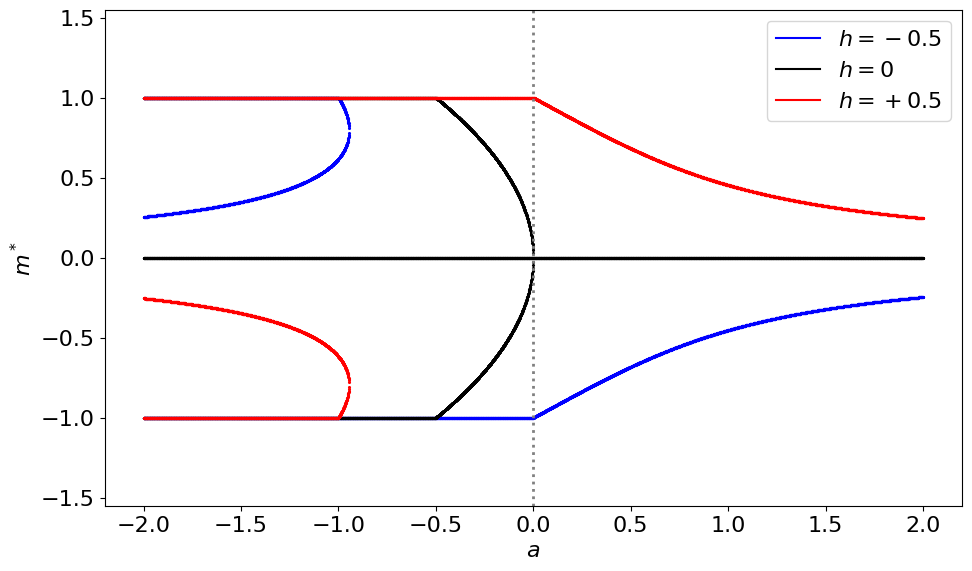

In [440]:
# Paramètres de Landau
b = 1.0
a_vals = np.linspace(-2, 2, 5000)
h_vals = [-0.5, 0.0, 0.5]  # différentes valeurs de h

# Résolution pour chaque h
plt.figure(figsize=(10,6))
colors = ['blue', 'black', 'red']
labels = [r"$h=-0.5$", r"$h=0$", r"$h=+0.5$"]

m_flat_stack = []
for h, color, label in zip(h_vals, colors, labels):
    m_list = []
    a_list = []
    for a in a_vals:
        # Résoudre 4b m^3 + 2a m - h = 0
        coeffs = [0.5*b, 0, a, -h]
        m_roots = np.roots(coeffs)
        # Garder seulement les solutions réelles
        m_real = m_roots[np.isreal(m_roots)].real
        m_list.append(m_real)
        a_list.append([a]*len(m_real))  # répéter 'a' pour chaque racine réelle

    a_flat = np.concatenate(a_list)
    m_flat = np.concatenate(m_list)
    m_flat_stack.append(m_flat)
    
    plt.plot(a_flat, np.array(m_flat)+10, linestyle="-", color=color, label=label)
    plt.plot(a_flat, np.clip(m_flat, -1,1), '.', color=color, markersize=2.5)#, label=label)

plt.axvline(0, color='grey', linestyle=':', linewidth=2)
plt.xlabel(r"$a$")
plt.ylabel(r"$m^*$")
#plt.title(r"Diagramme de bifurcation du modèle de Landau ($b=1$)")
#plt.title(r"$b=1$")
plt.ylim(-1.55, 1.55)
plt.legend()
plt.tight_layout()
plt.savefig("figures/diag_bifurc_landau.png", dpi=200)
plt.show()


### 4.2.3 - Visualisation de boucle d'hystérésis individuelle

Aire de la boucle d'hystérésis : 1.5020036459903008


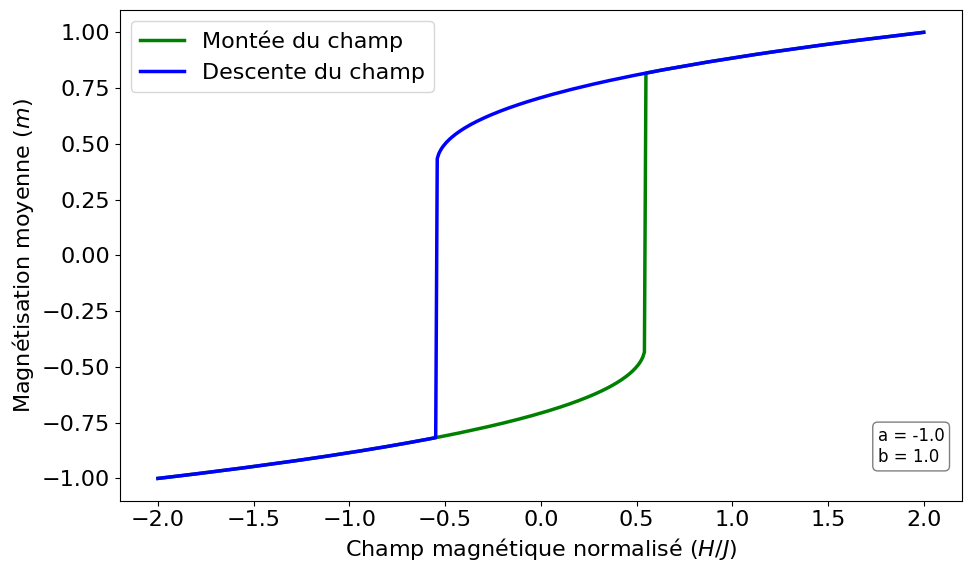

In [ ]:
# Paramètres du modèle de Landau
a = -1.0   # Coefficient du terme quadratique
b = 1.0    # Coefficient du terme quartique

def F(m, h):
    """ Énergie libre de Landau """
    return a * m**2 + 0.5*b * m**4 - h * m

def find_local_minimum(m_start, h):
    """Trouve le minimum local de F(m, h) en partant de m_start."""
    result = fmin(lambda m: F(m, h), m_start, disp=False)
    return result[0]

# Balayage du champ magnétique
h_vals = np.linspace(-2, 2, 500)
m_up = []
m_down = []

# Parcours montant (h croissant)
m_current = -1.0  # on part d'une aimantation négative
for h in h_vals:
    m_current = find_local_minimum(m_current, h)
    m_up.append(m_current)

# Parcours descendant (h décroissant)
m_current = 1.0  # on part d'une aimantation positive
for h in reversed(h_vals):
    m_current = find_local_minimum(m_current, h)
    m_down.append(m_current)

# Remettre m_down dans l'ordre de h_vals
m_down = m_down[::-1]

aire_hyst = simps(np.abs(np.array(m_up) - np.array(m_down)), h_vals)
print(f"Aire de la boucle d'hystérésis : {aire_hyst}")

# Tracer la boucle d'hystérésis
plt.figure(figsize=(10,6))
plt.plot(h_vals, m_up, linewidth=2.5, label="Montée du champ", color="green")
plt.plot(h_vals, m_down, linewidth=2.5, label="Descente du champ", color="blue")
plt.text(0.9*(np.max(h_vals)-np.min(h_vals))/4, 0.15, f"a = {a}\nb = {b}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.xlabel(r"Champ magnétique normalisé ($H/J$)")
plt.ylabel(r"Magnétisation moyenne ($m$)")
#plt.title("Boucle d'hystérésis dans le modèle de Landau")
plt.legend()
plt.tight_layout()
plt.savefig("figures/hysteresis_landau_exemple.pdf")
plt.show()

### 4.2.4 - Calcul des aires d'hystérésis pour un couple (a,b)

In [ ]:
def F(m, h, a, b):
    return  a*m**2 + 0.5*b*m**4 - h*m

def find_local_minimum(m_start, h, a, b):
    result = fmin(lambda m: F(m, h, a, b), m_start, disp=False)
    return result[0]


# Fonctions pour générer une boucle et calculer l'aire
def calculate_hysteresis_area(a, b, h_vals):
    #h_vals = np.linspace(h_min, h_max, num_points)
    m_up = []
    m_down = []

    # Montée du champ
    m_current = -1.0
    for h in h_vals:
        m_current = find_local_minimum(m_current, h, a ,b)
        m_up.append(m_current)

    # Descente du champ
    m_current = 1.0
    for h in reversed(h_vals):
        m_current = find_local_minimum(m_current, h, a, b)
        m_down.append(m_current)

    m_down = m_down[::-1]  # Remettre dans l'ordre

    # Calcul de l'aire entre montée et descente
    aire_hyst = simps(np.abs(np.array(m_up) - np.array(m_down)), h_vals)

    return aire_hyst

Fixons le paramètre $b=1$. Nous l'ajusterons ultérieurement. 

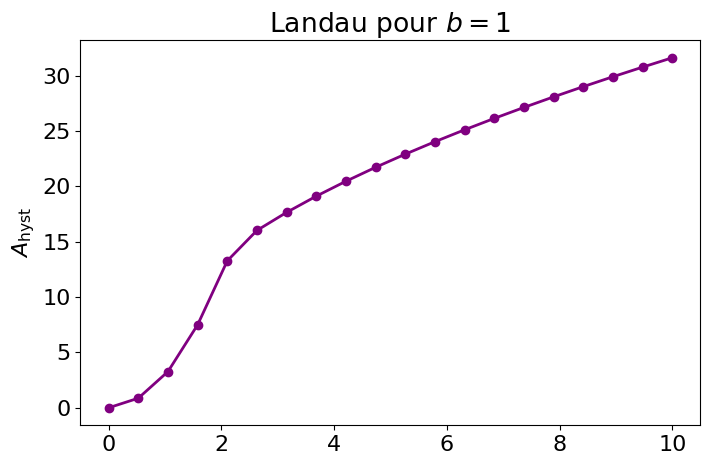

In [ ]:
a_values = np.linspace(-10.0, 0.0, 20)  # 20 valeurs de a décroissant de -2 vers 0
b = 1
h_vals = np.linspace(-2.5, 2.5, 50)
hysteresis_areas = []

for a in a_values:
    area = calculate_hysteresis_area(a, b, h_vals)
    hysteresis_areas.append(area)

# Tracer l'aire d'hystérésis en fonction de a
plt.figure(figsize=(8,5))
plt.plot(-a_values, hysteresis_areas, 'o-', color="purple", linewidth=2, label="Aire avec Landau")
plt.ylabel(r"$A_{\mathrm{hyst}}$")
plt.title("Landau pour $b=1$")
plt.show()


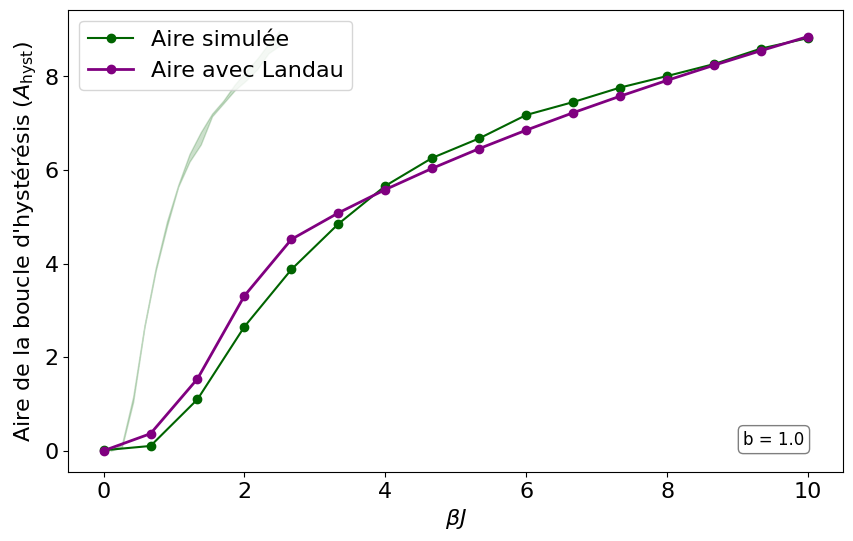

In [334]:
# Coefficient b reste fixé
b = 1.0
a_values = np.linspace(-10.0, 0.0, betaJ_vec.shape[0])  # 20 valeurs de a décroissant de -2 vers 0
h_vals = np.linspace(-2.5, 2.5, 50)

pente = -np.max(np.abs(a_values)) / np.max(betaJ_vec)
hysteresis_areas = []

for a in a_values:
    area = calculate_hysteresis_area(a, b, h_vals)
    hysteresis_areas.append(area)

plt.figure(figsize=(10,6))

plt.plot(-np.array(a_values), np.flip(area_means), 'o-', label="Aire simulée", color="darkGreen")
plt.plot(-a_values, np.array(hysteresis_areas)*0.28, 'o-', color="purple", linewidth=2, label="Aire avec Landau")
plt.fill_between(betaJ_vec, 
                 np.array(area_means) - np.array(area_stds), 
                 np.array(area_means) + np.array(area_stds), 
                 color="darkGreen", alpha=0.2)#, label=r"Variabilité ($\pm 1$ écart-type)")
plt.xlabel(r"$\beta J$")
plt.ylabel(r"$A_{\mathrm{hyst}}$")

plt.xlabel(r"$\beta J$")
plt.ylabel("Aire de la boucle d'hystérésis ($A_{\mathrm{hyst}}$)")
#plt.title("Ajustement de l'aire d'hystérésis avec le modèle de Landau")
plt.text(0.95, 0.05, f"b = {b}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.legend()
plt.show()

Ce tracé suit déjà de près celui de l'aire des boucles d'hystérésis de notre simulateur. Nous sommes sur la bonne voie!

### 4.2.5 - Balayons maintenant les deux paramètres

Nous allons effectuer une recherche en grille en balayant un rapport $a/b$ et un facteur global multiplicatif aux deux paramètres.

In [311]:
def objective(a, target_area, b_fixed, h_vals):
    predicted_area = calculate_hysteresis_area(a, b_fixed, h_vals)
    return (predicted_area - target_area)**2

In [297]:
def grid_search(factors, rapports, h_min=-2.5, h_max=2.5, h_steps=50):
    grid_dimension = factors.shape[0]
    rms_errors_grid_search = np.zeros((grid_dimension, grid_dimension), dtype="float")

    for a_, factor in tqdm(enumerate(factors), desc="Avancement des facteurs"):
        for b_,rapport in enumerate(rapports):

            h_vals = np.linspace(h_min, h_max, h_steps)  # Balayage du champ.
            a_simul_values = np.linspace(-1*factor*rapport, 0, betaJ_vec.shape[0])  # Exemple de valeurs de a simulées (un peu arbitraire).
            simulated_areas = np.flip(area_means)  # Aires d'hystérésis du simulateur.
            b_fixed = 1*factor # On fixe b pendant ce temps.

            # On optimise pour chaque point
            optimal_params = []  # Pour stocker les (a,b) optimaux.
            fitted_areas = []    # Et les aires associées.

            # Optimisation uniquement sur a, b restant fixe
            for i, target_area in enumerate(simulated_areas):
                a_guess = a_simul_values[i]  # point de départ pour a
                result = minimize(objective, [a_guess], args=(target_area, b_fixed, h_vals), bounds=[(-np.max(factors), 0)])
                a_opt = result.x[0]
                optimal_params.append((a_opt, b_fixed))

                fitted_area = calculate_hysteresis_area(a_opt, b_fixed, h_vals)
                fitted_areas.append(fitted_area)
                #print(f"Point {i}: a_opt = {a_opt:.3f}, b = {b_fixed}, aire simulée = {target_area:.3f}, aire ajustée = {fitted_area:.3f}")

            rms_errors_grid_search[a_][b_] = np.sqrt(np.mean((simulated_areas - fitted_areas) ** 2))

    return rms_errors_grid_search

In [403]:
grid_search_id = 8
factors = np.linspace(1, 50, 10)
rapports = np.linspace(0, 5, 10)

print("facteurs balayés : ", factors)
print("rapports balayés : ", rapports)

facteurs balayés :  [ 1.          6.44444444 11.88888889 17.33333333 22.77777778 28.22222222
 33.66666667 39.11111111 44.55555556 50.        ]
rapports balayés :  [0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]


In [404]:
# Effectuons la grid_search (long calcul, allez vous faire un café)

grid_search_result =  grid_search(factors, rapports)

Avancement des facteurs: 10it [04:00, 24.05s/it]


In [405]:
load_grid_search = False
#grid_search_id = 4

# Si on veut charger une grid search précédente :
if load_grid_search:
    grid_search_result = np.load(f"Data/grid_search_{fc.fill_index(grid_search_id)}.npy")
    factors = np.load(f"Data/factors_{fc.fill_index(grid_search_id)}.npy")
    rapports = np.load(f"Data/rapports_{fc.fill_index(grid_search_id)}.npy")

In [406]:
# Retrouvons la configuration qui minimise l'écart entre les deux courbes (approché par la statistique d'erreur RMS).
best_config_id = np.unravel_index(np.argmin(grid_search_result), grid_search_result.shape)
print("Meilleure configuration : ", best_config_id)

Meilleure configuration :  (2, 2)


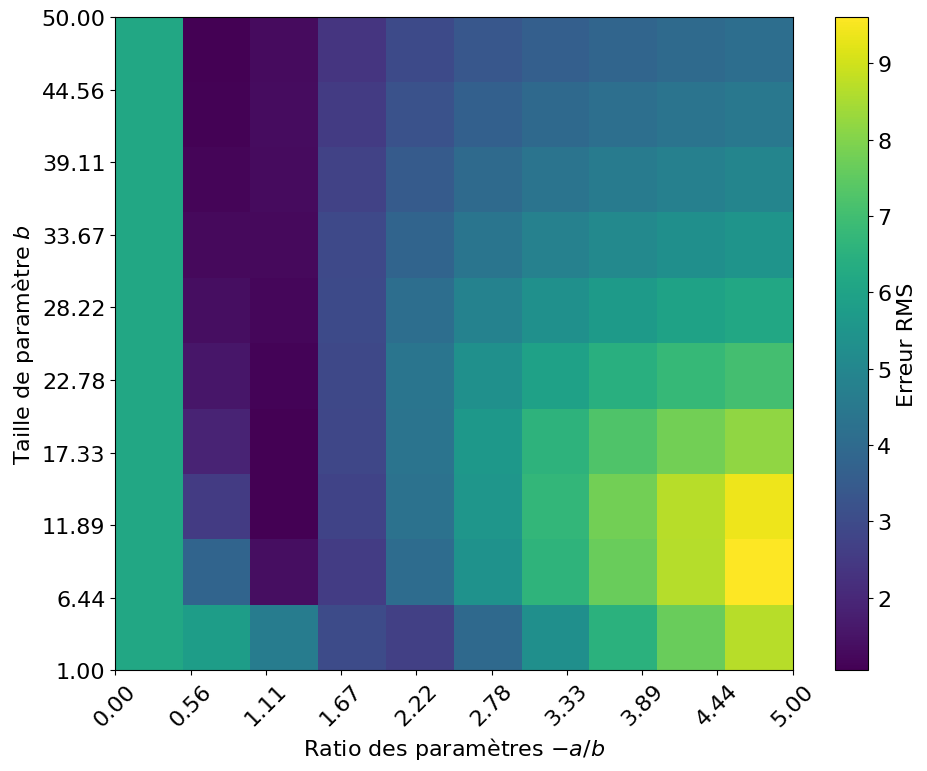

In [407]:
# Calcul des valeurs de a et b
a_values = -1 * factors[:] * rapports[:]
b_values = factors[:]

# Visualisation de la carte RMS avec les échelles de a et b
plt.figure(figsize=(10, 8))
plt.imshow(grid_search_result, origin='lower', aspect='auto', extent=[rapports.min(), rapports.max(), factors.min(), factors.max()])
plt.colorbar(label="Erreur RMS")
plt.xlabel(r"Ratio des paramètres $-a/b$")
plt.ylabel("Taille de paramètre $b$")

# Ajouter les ticks des axes avec les valeurs correspondantes de a et b
plt.xticks(rapports, labels=[f"{val:.2f}" for val in rapports], rotation=45)
plt.yticks(factors, labels=[f"{val:.2f}" for val in factors])

#plt.title("Carte de l'erreur RMS")
plt.tight_layout()
plt.savefig("figures/carte_RMS_exemple.pdf")
plt.show()


In [408]:
np.save(f"Data/grid_search_0{grid_search_id}.npy", grid_search_result)
np.save(f"Data/factors_{fc.fill_index(grid_search_id)}.npy", factors)
np.save(f"Data/rapports_{fc.fill_index(grid_search_id)}.npy", rapports)

In [409]:
a_best = -1 * factors[best_config_id[0]] * rapports[best_config_id[1]]
b_best = 1 * factors[best_config_id[0]]

print(a_best, b_best)

a_values_best = np.linspace(a_best, 0.0, betaJ_vec.shape[0])  # 20 valeurs de a décroissant de -2 vers 0
hysteresis_areas_best = []


h_min = -2.5
h_max = 2.5
h_steps = 50
h_vals = np.linspace(h_min, h_max, h_steps)

for a in a_values_best:
    area = calculate_hysteresis_area(a,b_best, h_vals)
    hysteresis_areas_best.append(area)

-13.209876543209878 11.88888888888889


-0.18168224299065416


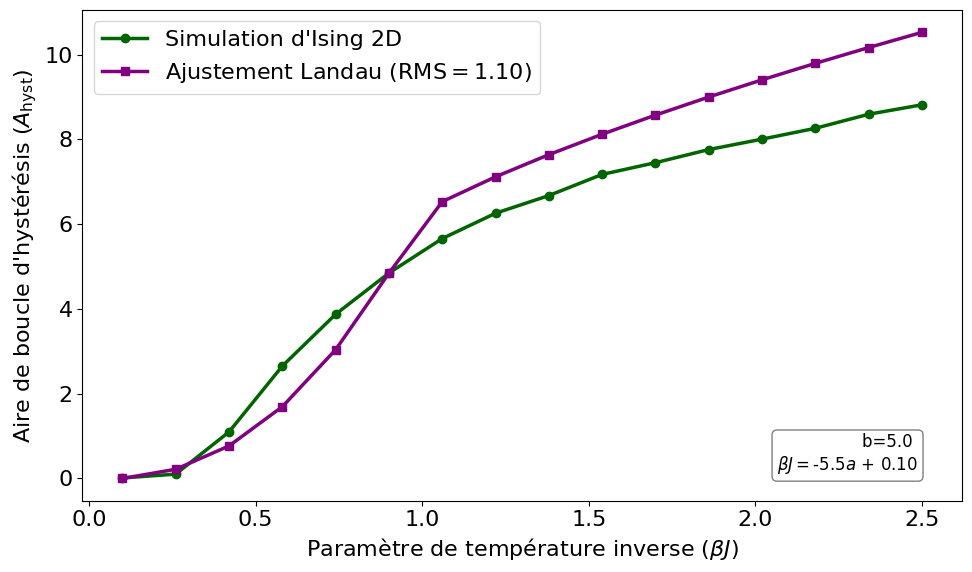

In [410]:
def RMS_error(courbe1, courbe2):
    return np.mean( (courbe1 - courbe2)**2 )

plt.figure(figsize=(10,6))

pente = -(np.max(betaJ_vec) -np.min(betaJ_vec))/ np.max(np.abs(a_values_best))
print(pente)

RMS_erreur_ente_landau_et_simuls = RMS_error(np.flip(area_means), np.array(hysteresis_areas_best))

plt.plot(np.array(a_values_best) * pente + np.min(betaJ_vec), np.flip(area_means), 'o-', linewidth=2.5, label="Simulation d'Ising 2D", color="darkGreen")
plt.plot(np.array(a_values_best) * pente + np.min(betaJ_vec), np.array(hysteresis_areas_best), 's-', linewidth=2.5, label=r"Ajustement Landau ($\mathrm{RMS} = $" + f"{RMS_erreur_ente_landau_et_simuls:.2f})", color="purple")


plt.xlabel(r"$\beta J$")
plt.ylabel(r"$A_{\mathrm{hyst}}$")

plt.xlabel(r"Paramètre de température inverse ($\beta J$)")
plt.ylabel("Aire de boucle d'hystérésis ($A_{\mathrm{hyst}}$)")
plt.text(0.95, 0.05, r"b=" + f"{b_fixed} \n" + r"$\beta J = $" + f"{(1/pente):.2}" + r"$a$" + f" + {np.min(betaJ_vec):.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.legend()
plt.tight_layout()
#plt.savefig("figures/aires_landau_vs_simul.pdf")
plt.show()

# 5 - Production de figures

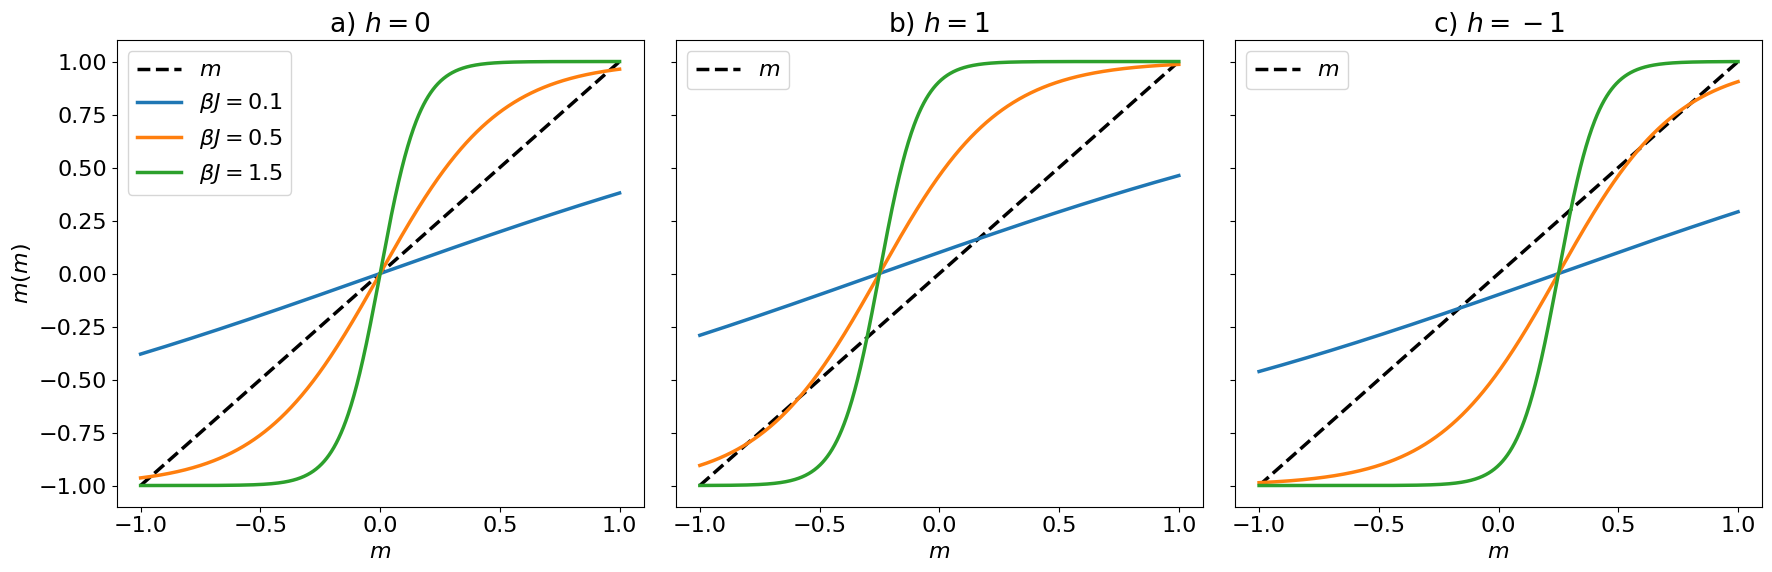

In [377]:
def fonc1(m):
    return m

def fonc2(m, betaJ, h):
    return np.tanh(betaJ*m*4 + betaJ*h)

m = np.linspace(-1, 1, 1000)

betaJ_values = [0.1, 0.5, 1.5]  
h_values = [0, 1, -1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
letters = ["a)", "b)", "c)"]
for i, h in enumerate(h_values):
    ax = axes[i]
    ax.plot(m, fonc1(m), color='black', linestyle='--',linewidth=2.5, label=r"$m$")
    for betaJ in betaJ_values:
        if i == 0:
            label = rf"$\beta J = {betaJ}$"
            ax.plot(m, fonc2(m, betaJ, h), linewidth=2.5, label=label)
        else:
            ax.plot(m, fonc2(m, betaJ, h), linewidth=2.5)

    ax.set_title(letters[i] + f" $h = {h}$")
    ax.set_xlabel(r"$m$")
    if i == 0:
        ax.set_ylabel(r"$m(m)$")
    ax.legend()

plt.tight_layout()
plt.savefig("figures/comparaison_solutions_transcendates.pdf")
plt.show()

# Code perdu

In [ ]:
def solve_mean_field(betaJ, h, J, tol=1e-6, max_iter=1000):
    m = 0.0  # Condition initiale
    for _ in range(max_iter):
        m_new = np.tanh(betaJ * (h + J * m))
        if abs(m_new - m) < tol:
            return m_new
        m = m_new
    raise ValueError("Solution n'a pas convergé")

J = 1.0  # Ouplage
h = 0.5  # Champ magnétique externe
betaJ = 1.5  # BetaJ

m_solution = solve_mean_field(betaJ, h, J)
print("Solution for m:", m_solution)


# Calculer l'intégrale de |m(betaJ)| sur h_vec_filtered
magnetic_work = simps(np.abs(mean_mag_filtered), h_vec_filtered)

print("Travail magnétique (aire de la boucle d'hystérèse) :", magnetic_work)

# Calcul des aires théoriques pour différentes valeurs de betaJ
theoretical_areas = []

for betaJ in betaJ_vec:
    m_values = [solve_mean_field(betaJ, h, J) for h in h_vec_filtered]
    area_theoretical = simps(np.abs(m_values), h_vec_filtered)
    theoretical_areas.append(area_theoretical)

# Tracer les aires théoriques et expérimentales
plt.figure(figsize=(10, 6))
plt.plot(betaJ_list, area_means, 'o-', color="darkGreen", label="Expérimental", linewidth=2)
plt.fill_between(betaJ_list, 
                 np.array(area_means) - np.array(area_stds), 
                 np.array(area_means) + np.array(area_stds), 
                 color="darkGreen", alpha=0.2)#, label=r"Variabilité ($\pm 1$ écart-type)")
plt.plot(betaJ_vec, theoretical_areas, 's-', color="darkBlue", label="Théorique", linewidth=2)
plt.xlabel(r"$\beta J$")
plt.ylabel(r"$A_{\mathrm{hyst}}$")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def save_simulation_to_hdf5(filename, h_val, run_id, sim, lattices, spin_means, energy_list):
    with h5py.File(filename, 'a') as f:
        h_group_name = f"h={h_val:+.2f}"
        if h_group_name not in f:
            h_grp = f.create_group(h_group_name)
            h_grp.attrs["magnetic_field"] = h_val
        else:
            h_grp = f[h_group_name]

        run_group_name = f"run_{run_id:04d}"
        if run_group_name in h_grp:
            print(f"Warning: {h_group_name}/{run_group_name} already exists. Skipping save.")
            return

        run_grp = h_grp.create_group(run_group_name)
        run_grp.create_dataset("initial_lattice", data=sim.lattice)
        run_grp.create_dataset("final_lattice", data=lattices[-1])
        run_grp.create_dataset("energy", data=energy_list)
        run_grp.create_dataset("magnetization", data=spin_means)

        # Attributs du run
        run_grp.attrs["seed"] = sim.seed
        run_grp.attrs["betaJ"] = sim.betaJ
        run_grp.attrs["pourcentage_up"] = sim.up_perc
        run_grp.attrs["n_iter"] = sim.n_iter
        run_grp.attrs["convol"] = sim.convol

def run_batch_simulations(h_range, n_seeds, filename="results.h5"):
    betaJ = 1.0
    size = 64
    pourcentage_up = 0.5

    final_magnetizations = []
    std_magnetizations = []

    for h in tqdm(h_range, desc="Variation du champ magnétique"):
        mags = []
        for run_id in range(n_seeds):
            seed = np.random.randint(0, int(1e6))
            sim = Metropolis(
                n_iter=0,
                lattice_size=size,
                magnetic_field=h,
                betaJ=betaJ,
                pourcentage_up=pourcentage_up,
                convol="scipy",
                seed=seed
            )
            lattices, spin_means, energy_list = sim.run()
            save_simulation_to_hdf5(filename, h, run_id, sim, lattices, spin_means, energy_list)
            mags.append(spin_means[-1])

        final_magnetizations.append(np.mean(mags))
        std_magnetizations.append(np.std(mags))

    return h_range, final_magnetizations, std_magnetizations


In [ ]:
dataset_name = "run_0001"  # Remplacez par le nom du groupe que vous voulez lire

data= {}

with h5py.File(data_folder + "results.h5", "r") as file:
    print("Clefs du fichier :", list(file.keys()))
    
    if dataset_name in file:
        group = file[dataset_name]
        data= group
        print(f"Attributs du groupe {dataset_name}:", dict(group.attrs))
        initial_lattice = group["initial_lattice"][:]
        final_lattice = group["final_lattice"][:]
        energy = group["energy"][:]
        magnetization = group["magnetization"][:]
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Grille initiale")
        plt.imshow(initial_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.title("Grille finale")
        plt.imshow(final_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        print("Énergie :", energy)
        print("Magnétisation :", magnetization)
    else:
        print(f"Le groupe {dataset_name} n'existe pas dans le fichier.")